<a href="https://colab.research.google.com/github/AlvaroMAlves/Saver-s-Match/blob/main/New_Retirement_plan_Saver's_Match.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto: New Retirement plan: Saver's Match

## Calculando novos valores

Aqui, irei criar um df 'dados', com duas novas colunas: additional_retirement_savings, que é o valor que poderá ser aucmulado com o novo plano de aposentadoria Saver's Match, e new_accumulated_capital, que será a soma do acumulado no plano antigo e no novo.

In [83]:
import pandas as pd

url = 'https://raw.githubusercontent.com/AlvaroMAlves/Saver-s-Match/main/data.csv'
dados = pd.read_csv(url)
# Dataset is now stored in a Pandas Dataframe

In [84]:
dados.describe()

,Unnamed: 0,initial_age,weight,family_kind,race,marital_status,accumulated_capital,annual_contribution,income
count,47626.000000,47626.000000,47626.000000,47626.000000,47626.000000,47626.000000,4.762600e+04,47626.000000,47626.000000
mean,23812.500000,48.379793,1551.159535,1.730756,1.693634,2.245454,2.483036e+04,0.175277,70240.892997
std,13748.586297,8.064861,942.788098,0.852361,1.014817,1.554839,1.705045e+05,0.101389,49720.565014
min,0.000000,35.000000,98.000000,1.000000,1.000000,1.000000,-5.119091e+05,0.000000,250.650000
25%,11906.250000,42.000000,811.250000,1.000000,1.000000,1.000000,-8.116163e+04,0.090000,33878.760000
50%,23812.500000,48.000000,1500.000000,1.000000,1.000000,1.000000,2.280218e+04,0.180000,59084.150000
75%,35718.750000,55.000000,1971.000000,3.000000,2.000000,3.000000,1.016781e+05,0.260000,94320.602500
max,47625.000000,63.000000,9349.000000,3.000000,4.000000,5.000000,1.111905e+06,0.350000,473601.750000


In [85]:
import math
import numpy as np

# Função para calcular o novo valor de income a cada ano
def calculate_adjusted_income(initial_income, initial_age, current_age):
    inflation_rate = 0.044  # Taxa de inflação anual de 4,4%
    years_passed = current_age - initial_age
    adjusted_income = initial_income * (1 + inflation_rate) ** years_passed
    return adjusted_income

# Criando a coluna additional_retirement_savings preenchida com zeros
dados['additional_retirement_savings'] = 0

# Criando uma lista para armazenar as contribuições
contributions = []

# Iterando sobre as linhas do dataframe
for index, row in dados.iterrows():
    # Obtendo os valores das colunas relevantes
    family_kind = row['family_kind']
    marital_status = row['marital_status']
    initial_income = row['income']
    annual_contribution = row['annual_contribution']
    initial_age = row['initial_age']

    # Iniciando as variáveis com as faixas principais, levando em conta casais com contas conjuntas.
    # De acordo com algumas pesquisas, estipulei que serão três faixas:
    #
    #     threshold: incomes até 41000 (inclusive) terão um depósito do governo de 50%
    #                sobre o total da contribuição anual na conta de aposentadoria, até o limit_amount de 5000
    #
    #     phaseout: incomes entre 41000 e 45000 (inclusive) terão um depósito de 20%
    #
    #     limit: incomes entre 45000 e 71000 (inclusive) terão um depósito de 10%
    #
    # Embora haja uma questão na lei que dizendo sobre alguns casos em que viúvas também possam participar
    # dessa faixa principal, não considerei isso em meu projeto.
    limit_amount = 5000
    threshold = 41000
    phaseout = 45000
    limit = 71000

    # Alterando as faixas para 75% do valor principal, caso sejam chefes de família casados,
    # ou 50% do valor principal caso sejam solteiros.
    if family_kind == 2 or family_kind == 3:
        if marital_status == 1:
            threshold = 0.75 * threshold
            phaseout = 0.75 * phaseout
            limit = 0.75 * limit
        else:
            threshold = 0.5 * threshold
            phaseout = 0.5 * phaseout
            limit = 0.5 * limit

    # Iterando até a idade de 65 anos, recalculando as faixas e o income anualmente
    additional_retirement_savings = 0  # Variável para acumular as contribuições
    for age in range(int(initial_age), 66):
        # Recalculando o income
        current_income = calculate_adjusted_income(initial_income, initial_age, age)

        # Verificando se o income está dentro das faixas para calcular o additional_retirement_savings
        if current_income <= threshold:
            contribution = min(current_income * annual_contribution * 0.5, limit_amount)
        elif current_income <= phaseout:
            contribution = min(current_income * annual_contribution * 0.2, limit_amount)
        elif current_income <= limit:
            contribution = min(current_income * annual_contribution * 0.1, limit_amount)
        else:
            contribution = 0

        # Corrigindo os valores com a inflação (no caso das faixas, assumi que seja sempre um múltiplo de 100, de acordo com algumas pesquisas que fiz.
        # Atualmente, esse valor é arredondado para o múltiplo mais próximo de 500).
        # Isso faz com que algumas linhas acabem entrando e saindo das faixas, devido ao income crescer sem esse arredondamento.
        limit_amount = limit_amount * (1 + 0.044)
        threshold = round(threshold * (1 + 0.044), -2)
        phaseout = round(phaseout * (1 + 0.044), -2)
        limit = round(limit * (1 + 0.044), -2)

        # Acumulando o valor de additional_retirement_savings
        additional_retirement_savings += contribution

    # Adicionando o valor acumulado à lista de contribuições
    contributions.append(additional_retirement_savings)

# Atribuindo a lista de contribuições à coluna additional_retirement_savings do dataframe
dados['additional_retirement_savings'] = contributions

# Calculando o valor da coluna new_accumulated_capital
dados['new_accumulated_capital'] = dados['additional_retirement_savings']

# Iterando sobre as linhas do dataframe novamente
for index, row in dados.iterrows():
    initial_age = row['initial_age']
    add_ret_sav = row['additional_retirement_savings']
    acc_cap = row['accumulated_capital']

    # Calculando o ano final da simulação
    final_year = int(2020 + 65 - initial_age)

    # Atualizando o valor do capital acumulado
    dados.loc[index, 'new_accumulated_capital'] = add_ret_sav + acc_cap

Além de criar a coluna 'new_accumulated_capital', achei útil também ter a additional_retirement_savings. Passando a df 'dados' para csv:

In [87]:
from google.colab import files

# Salvar o DataFrame em um arquivo CSV
dados.to_csv('new_scenario.csv', index=False)

# Fazer o download do arquivo CSV
files.download('new_scenario.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Gráfico: Weighted Average Retirement Savings Shortfall by Age Cohort and Age

Primeiro, gerar os dados, para visualizá-los:

In [88]:
# Definir as faixas etárias e raças
age_cohorts = [[35, 39], [40, 44], [45, 49], [50, 54], [55, 59], [60, 64]]
races = [1, 2, 3, 4]

# Criar uma lista para armazenar os resultados
results = []

# Iterar sobre as faixas etárias e raças
for age_range in age_cohorts:
    lower_age = age_range[0]
    upper_age = age_range[1]

    for race in races:
        # Filtrar o DataFrame com base na faixa etária, raça e valores negativos
        filtered_data = dados[(dados['initial_age'] >= lower_age) & (dados['initial_age'] <= upper_age) & (dados['race'] == race) & (dados['new_accumulated_capital'] < 0)]

        # Calcular a média ponderada apenas se houver valores negativos
        if not filtered_data.empty:
            weighted_average = (filtered_data['new_accumulated_capital'] * filtered_data['weight']).sum() / filtered_data['weight'].sum()
        else:
            weighted_average = 0

        # Adicionar o resultado à lista de resultados
        results.append({'Age Cohort': age_range, 'Race': race, 'Weighted Average Retirement Savings Shortfall': weighted_average})

# Criar um novo DataFrame com os resultados
result_df = pd.DataFrame(results)

# Imprimir o DataFrame resultante
print(result_df)

   Age Cohort  Race  Weighted Average Retirement Savings Shortfall
0    [35, 39]     1                                 -118626.927539
1    [35, 39]     2                                 -123998.608129
2    [35, 39]     3                                 -116971.547488
3    [35, 39]     4                                 -107320.667796
4    [40, 44]     1                                 -114506.112913
5    [40, 44]     2                                 -116368.828826
6    [40, 44]     3                                 -122083.008901
7    [40, 44]     4                                 -115339.420406
8    [45, 49]     1                                 -119647.995115
9    [45, 49]     2                                 -119261.283965
10   [45, 49]     3                                 -125395.706616
11   [45, 49]     4                                 -114146.711638
12   [50, 54]     1                                 -118634.912990
13   [50, 54]     2                                 -129632.92

O gráfico de barras será ordenado do mais negativo para o menos negativo:

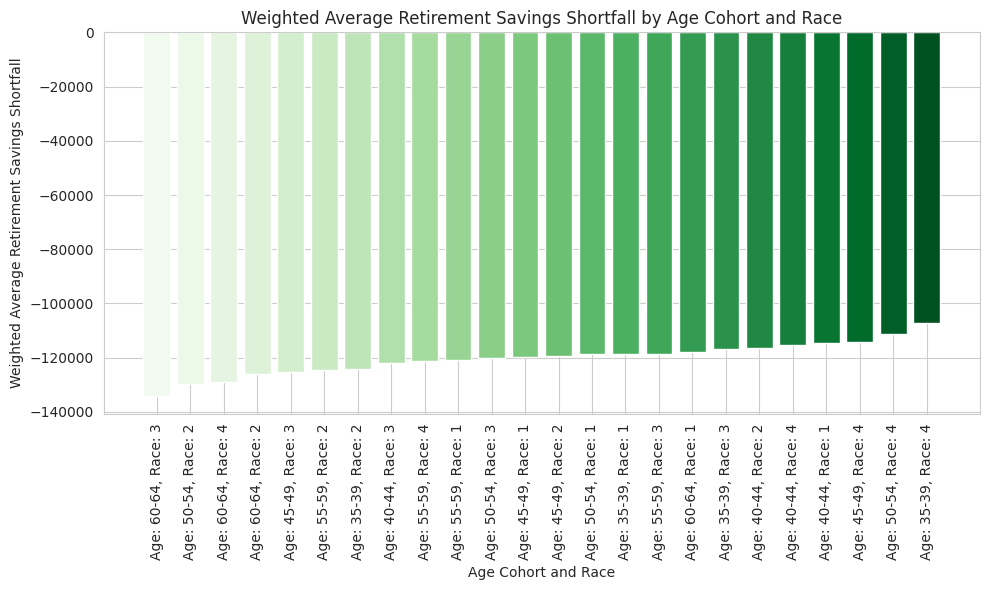

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir as faixas etárias e raças
age_cohorts = [[35, 39], [40, 44], [45, 49], [50, 54], [55, 59], [60, 64]]
races = [1, 2, 3, 4]

# Criar uma lista para armazenar os resultados
results = []

# Iterar sobre as faixas etárias e raças
for age_range in age_cohorts:
    lower_age = age_range[0]
    upper_age = age_range[1]

    for race in races:
        # Filtrar o DataFrame com base na faixa etária e raça
        filtered_data = dados[(dados['initial_age'] >= lower_age) & (dados['initial_age'] <= upper_age) & (dados['race'] == race) & (dados['new_accumulated_capital'] < 0)]

        weighted_sum = ((filtered_data['new_accumulated_capital'] * filtered_data['weight']).sum()) / filtered_data['weight'].sum()

        # Adicionar o resultado à lista de resultados
        results.append({'Age Cohort': age_range, 'Race': race, 'Weighted Average Retirement Savings Shortfall': weighted_sum})

# Criar um novo DataFrame com os resultados
result_df = pd.DataFrame(results)

# Ordenar o DataFrame pelos valores em ordem crescente
result_df = result_df.sort_values('Weighted Average Retirement Savings Shortfall')

# Resetar os índices do DataFrame ordenado
result_df = result_df.reset_index(drop=True)

# Plotar gráfico de barras
plt.figure(figsize=(10, 6))  # Define o tamanho da figura

# Configurar as cores das barras usando uma paleta de cores
colors = sns.color_palette('Greens', len(result_df))

# Plotar as barras com cores diferentes
bars = plt.bar(range(len(result_df)), result_df['Weighted Average Retirement Savings Shortfall'], align='center', color=colors)

# Configurar os rótulos do eixo x
x_ticks = [f'Age: {age_range[0]}-{age_range[1]}, Race: {race}' for age_range, race in zip(result_df['Age Cohort'], result_df['Race'])]
plt.xticks(range(len(result_df)), x_ticks, rotation='vertical')


# Definir rótulos e títulos do gráfico
plt.xlabel('Age Cohort and Race')
plt.ylabel('Weighted Average Retirement Savings Shortfall')
plt.title('Weighted Average Retirement Savings Shortfall by Age Cohort and Race')

# Exibir o gráfico
plt.tight_layout()
plt.show()

## Gráfico: Impact per Age Cohort

O impacto percentual será calculado pela variação percentual das razões entre a quantidade de positivos antes do Saver's Match pela população e a quantidade de positivos depois da Saver's Match pela população.

In [92]:
# Definir as faixas etárias
age_cohorts = [[35, 39], [40, 44], [45, 49], [50, 54], [55, 59], [60, 64]]

results = []

for age_range in age_cohorts:
    lower_age = age_range[0]
    upper_age = age_range[1]

    # Filtrar o DataFrame com base na faixa etária
    filtered_data = dados[(dados['initial_age'] >= lower_age) & (dados['initial_age'] <= upper_age)]

    # Filtrar apenas os valores positivos de accumulated_capital
    positive_accumulated_capital = filtered_data[filtered_data['accumulated_capital'] > 0]

    # Filtrar apenas os valores positivos de new_accumulated_capital
    positive_new_accumulated_capital = filtered_data[filtered_data['new_accumulated_capital'] > 0]

    # Contar a quantidade de valores positivos de accumulated_capital
    count_positive_accumulated_capital = positive_accumulated_capital.shape[0]

    # Contar a quantidade de valores positivos de new_accumulated_capital
    count_positive_new_accumulated_capital = positive_new_accumulated_capital.shape[0]

    # Calcular a soma dos weights
    weight_sum = filtered_data['weight'].sum()

    # Calcular a razão Count Positive Accumulated Capital / Weight Sum
    ratio_positive_accumulated_capital = count_positive_accumulated_capital / weight_sum

    # Calcular a razão Count Positive New Accumulated Capital / Weight Sum
    ratio_positive_new_accumulated_capital = count_positive_new_accumulated_capital / weight_sum

    # Calcular a variação percentual entre as razões
    impact = ((ratio_positive_new_accumulated_capital - ratio_positive_accumulated_capital) / ratio_positive_accumulated_capital) * 100

    results.append({'Age Cohort': age_range, 'Count Positive Accumulated Capital': count_positive_accumulated_capital,
                    'Count Positive New Accumulated Capital': count_positive_new_accumulated_capital,
                    'Weight Sum': weight_sum,
                    'Ratio Positive Accumulated Capital': ratio_positive_accumulated_capital,
                    'Ratio Positive New Accumulated Capital': ratio_positive_new_accumulated_capital,
                    'Impact (%)': impact})

# Criar um DataFrame com os resultados
result_df = pd.DataFrame(results)

# Imprimir o DataFrame resultante
print(result_df)

  Age Cohort  Count Positive Accumulated Capital  \
0   [35, 39]                                5135   
1   [40, 44]                                5474   
2   [45, 49]                                5243   
3   [50, 54]                                4929   
4   [55, 59]                                4443   
5   [60, 64]                                2950   

   Count Positive New Accumulated Capital  Weight Sum  \
0                                    5610    11943009   
1                                    5898    12831567   
2                                    5552    12976780   
3                                    5147    13877625   
4                                    4554    13180417   
5                                    2981     9066126   

   Ratio Positive Accumulated Capital  Ratio Positive New Accumulated Capital  \
0                            0.000430                                0.000470   
1                            0.000427                                0.00

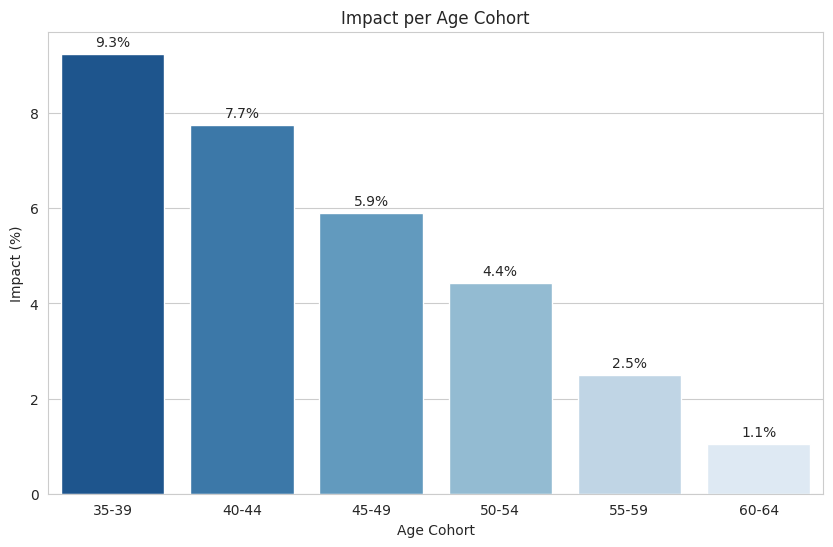

In [94]:
# Configurar o estilo do Seaborn
sns.set_style('whitegrid')

# Inverter a ordem da paleta de cores
palette = sns.color_palette('Blues', len(result_df))[::-1]

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=[f'{age_range[0]}-{age_range[1]}' for age_range in result_df['Age Cohort']],
                   y=result_df['Impact (%)'],
                   palette=palette)

# Adicionar os valores nas barras
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{height:.1f}%', ha='center', va='bottom')

# Configurar os labels e o título
plt.xlabel('Age Cohort')
plt.ylabel('Impact (%)')
plt.title('Impact per Age Cohort')

# Exibir o gráfico
plt.show()